# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [19]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/pshvaiko/Desktop/kth_scalable_ml/hw1/mlfs-book
HopsworksSettings initialized!


In [60]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [21]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 17, 13, 6, 35, 935080)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [22]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-17 13:06:38,240 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-17 13:06:38,247 INFO: Initializing external client
2025-11-17 13:06:38,249 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-17 13:06:39,244 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 13:06:40,302 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1298580


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [23]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_vanilla_lag_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-17 13:07:05,664 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/101230 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/48 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19311 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/496832 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25988 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105759 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/46 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19858 elapsed<00:00 remaining<?

In [24]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.5512856E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [26]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values("date").reset_index(drop=True)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.12s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-18 00:00:00+00:00,17.950001,0.0,4.394360,214.992096,malaga
1,2025-11-19 00:00:00+00:00,17.600000,0.0,3.826853,221.185822,malaga
2,2025-11-20 00:00:00+00:00,17.600000,0.0,10.636766,246.037506,malaga
3,2025-11-21 00:00:00+00:00,12.300000,0.0,24.569832,349.019379,malaga
4,2025-11-22 00:00:00+00:00,13.900000,0.0,10.948973,313.667847,malaga
5,2025-11-23 00:00:00+00:00,16.350000,0.0,5.351785,312.273621,malaga


In [34]:
# Getting recent pm25 history to construct lagged features
air_quality_fg = fs.get_feature_group(
    name="air_quality_lagged",
    version=1
)

history_df = air_quality_fg.read()
history_df = history_df.sort_values("date").reset_index(drop=True)

# Select the last 3 rows
last_three = history_df.tail(3)
print(last_three)
pm25_vals = last_three["pm25"].tolist()

# TODO: maybe handle by providing the best predicted pm25 for those days (like the average)
if len(pm25_vals) < 3:
    raise ValueError("Not enough history to build 3 lagged pm25 values")

# lags[0] = yesterday, lags[1] = 2 days ago, lags[2] = 3 days ago
pm25_lags = pm25_vals[-1], pm25_vals[-2], pm25_vals[-3]  # (pm25_t-1, pm25_t-2, pm25_t-3)

# Show them
pm25_lags

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.00s) 
                          date  pm25 country    city     street  \
2769 2025-07-29 00:00:00+00:00  26.0   spain  malaga  el-atabal   
2770 2025-07-30 00:00:00+00:00  29.0   spain  malaga  el-atabal   
2771 2025-11-17 00:00:00+00:00  19.0   spain  malaga  el-atabal   

                                   url  pm25_lag_1  pm25_lag_2  pm25_lag_3  
2769  https://api.waqi.info/feed/@8487        28.0        27.0        42.0  
2770  https://api.waqi.info/feed/@8487        26.0        28.0        27.0  
2771  https://api.waqi.info/feed/@8487        29.0        26.0        28.0  


(19.0, 29.0, 26.0)

In [37]:
import pandas as pd

rows = []
lags = list(pm25_lags) # [lag1, lag2, lag3] = [y_{t-1}, y_{t-2}, y_{t-3}]

train_feature_cols = retrieved_xgboost_model.get_booster().feature_names
print("Model feature order:", train_feature_cols)

for _, row in batch_data.iterrows():
    # Build feature row: weather + lags
    feature_row = {
        "temperature_2m_mean": row["temperature_2m_mean"],
        "precipitation_sum": row["precipitation_sum"],
        "wind_speed_10m_max": row["wind_speed_10m_max"],
        "wind_direction_10m_dominant": row["wind_direction_10m_dominant"],
        "pm25_lag_1": lags[0],
        "pm25_lag_2": lags[1],
        "pm25_lag_3": lags[2],
    }

    X_one = pd.DataFrame([feature_row])

    # Reorder columns to match training
    X_one = X_one[train_feature_cols]

    # Predict pm25 for this day
    y_hat = float(retrieved_xgboost_model.predict(X_one)[0])

    # Store full row for output
    out_row = {
        "date": row["date"],
        "city": row["city"],
        "temperature_2m_mean": row["temperature_2m_mean"],
        "precipitation_sum": row["precipitation_sum"],
        "wind_speed_10m_max": row["wind_speed_10m_max"],
        "wind_direction_10m_dominant": row["wind_direction_10m_dominant"],
        "pm25_lag_1": lags[0],
        "pm25_lag_2": lags[1],
        "pm25_lag_3": lags[2],
        "predicted_pm25": y_hat,
    }
    rows.append(out_row)

    # Update lags for next day: new y_hat becomes "yesterday"
    lags = [y_hat, lags[0], lags[1]]

prediction_df = pd.DataFrame(rows)
prediction_df = prediction_df.sort_values("date").reset_index(drop=True)
prediction_df



Model feature order: ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']


,date,city,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25
0,2025-11-18 00:00:00+00:00,malaga,17.950001,0.0,4.394360,214.992096,19.000000,29.000000,26.000000,17.339233
1,2025-11-19 00:00:00+00:00,malaga,17.600000,0.0,3.826853,221.185822,17.339233,19.000000,29.000000,35.922016
2,2025-11-20 00:00:00+00:00,malaga,17.600000,0.0,10.636766,246.037506,35.922016,17.339233,19.000000,18.462976
3,2025-11-21 00:00:00+00:00,malaga,12.300000,0.0,24.569832,349.019379,18.462976,35.922016,17.339233,22.161934
4,2025-11-22 00:00:00+00:00,malaga,13.900000,0.0,10.948973,313.667847,22.161934,18.462976,35.922016,25.861576
5,2025-11-23 00:00:00+00:00,malaga,16.350000,0.0,5.351785,312.273621,25.861576,22.161934,18.462976,30.268864


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
# batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-18 00:00:00+00:00,17.900000,0.0,5.860375,227.489594,malaga,42.504475
1,2025-11-22 00:00:00+00:00,11.500000,0.0,9.504273,294.623535,malaga,42.840839
2,2025-11-20 00:00:00+00:00,17.750000,0.0,13.905509,248.749420,malaga,49.332539
3,2025-11-21 00:00:00+00:00,11.450000,0.0,29.237675,350.073822,malaga,26.457785
4,2025-11-19 00:00:00+00:00,17.700001,0.0,4.896530,216.027466,malaga,53.634109
5,2025-11-17 00:00:00+00:00,16.850000,0.0,19.319628,243.435013,malaga,38.078865


In [47]:
float_cols = [
    "temperature_2m_mean",
    "precipitation_sum",
    "wind_speed_10m_max",
    "wind_direction_10m_dominant",
    "predicted_pm25",
    "pm25_lag_1",
    "pm25_lag_2",
    "pm25_lag_3",
]

for c in float_cols:
    if c in prediction_df.columns:
        prediction_df[c] = prediction_df[c].astype("float32")

prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[ns, Etc/UTC]
 1   city                         6 non-null      object                 
 2   temperature_2m_mean          6 non-null      float32                
 3   precipitation_sum            6 non-null      float32                
 4   wind_speed_10m_max           6 non-null      float32                
 5   wind_direction_10m_dominant  6 non-null      float32                
 6   pm25_lag_1                   6 non-null      float32                
 7   pm25_lag_2                   6 non-null      float32                
 8   pm25_lag_3                   6 non-null      float32                
 9   predicted_pm25               6 non-null      float32                
 10  street

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [48]:
prediction_df['street'] = street
prediction_df['city'] = city
prediction_df['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
prediction_df['days_before_forecast_day'] = range(1, len(prediction_df)+1)
prediction_df = prediction_df.sort_values(by=['date'])
prediction_df

,date,city,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-18 00:00:00+00:00,malaga,17.950001,0.0,4.394360,214.992096,19.000000,29.000000,26.000000,17.339233,el-atabal,spain,1
1,2025-11-19 00:00:00+00:00,malaga,17.600000,0.0,3.826853,221.185822,17.339233,19.000000,29.000000,35.922016,el-atabal,spain,2
2,2025-11-20 00:00:00+00:00,malaga,17.600000,0.0,10.636766,246.037506,35.922016,17.339233,19.000000,18.462976,el-atabal,spain,3
3,2025-11-21 00:00:00+00:00,malaga,12.300000,0.0,24.569832,349.019379,18.462976,35.922016,17.339233,22.161934,el-atabal,spain,4
4,2025-11-22 00:00:00+00:00,malaga,13.900000,0.0,10.948973,313.667847,22.161934,18.462976,35.922016,25.861576,el-atabal,spain,5
5,2025-11-23 00:00:00+00:00,malaga,16.350000,0.0,5.351785,312.273621,25.861576,22.161934,18.462976,30.268864,el-atabal,spain,6


In [49]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[ns, Etc/UTC]
 1   city                         6 non-null      object                 
 2   temperature_2m_mean          6 non-null      float32                
 3   precipitation_sum            6 non-null      float32                
 4   wind_speed_10m_max           6 non-null      float32                
 5   wind_direction_10m_dominant  6 non-null      float32                
 6   pm25_lag_1                   6 non-null      float32                
 7   pm25_lag_2                   6 non-null      float32                
 8   pm25_lag_3                   6 non-null      float32                
 9   predicted_pm25               6 non-null      float32                
 10  street

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

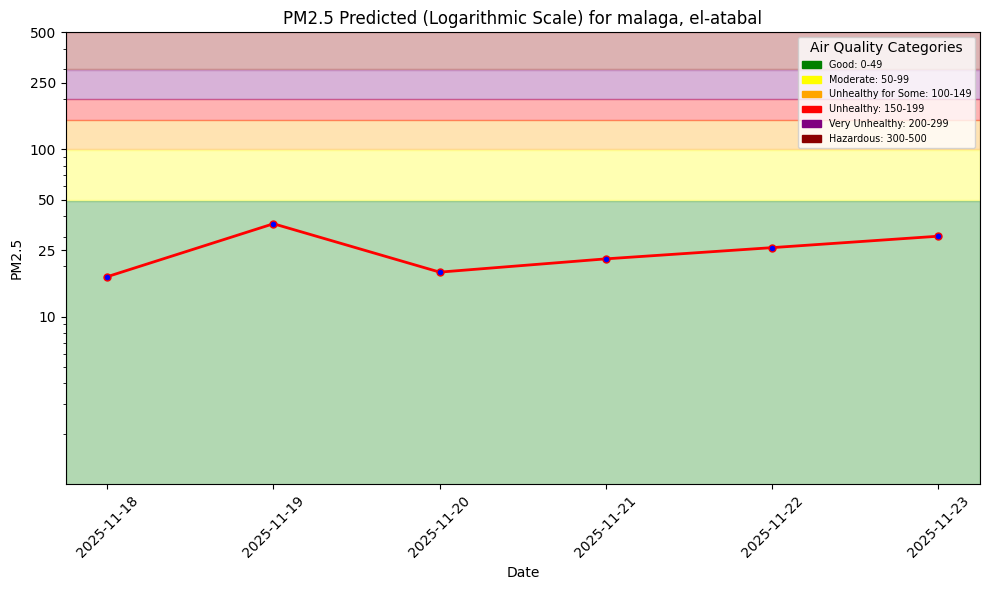

In [50]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, prediction_df, pred_file_path)

plt.show()

In [51]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_with_lag',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3'],
    event_time="date"
)

In [52]:
monitor_fg.insert(prediction_df, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1298580/fs/1286211/fg/1718805


Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_with_lag_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298580/jobs/named/aq_predictions_with_lag_1_offline_fg_materialization/executions
2025-11-17 14:45:15,341 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 14:45:18,524 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 14:46:48,017 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 14:46:48,219 INFO: Waiting for log aggregation to finish.
2025-11-17 14:46:56,875 INFO: Execution finished successfully.


(Job('aq_predictions_with_lag_1_offline_fg_materialization', 'SPARK'), None)

In [66]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 


,date,city,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-18 00:00:00+00:00,malaga,17.950001,0.0,4.39436,214.992096,19.0,29.0,26.0,17.339233,el-atabal,spain,1


In [67]:
air_quality_fg = fs.get_feature_group(name='air_quality_lagged', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.47s) 


,date,pm25,country,city,street,url,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2018-02-22 00:00:00+00:00,38.0,spain,malaga,el-atabal,https://api.waqi.info/feed/@8487,35.0,45.0,48.0
1,2018-08-20 00:00:00+00:00,19.0,spain,malaga,el-atabal,https://api.waqi.info/feed/@8487,16.0,24.0,32.0
2,2018-08-08 00:00:00+00:00,20.0,spain,malaga,el-atabal,https://api.waqi.info/feed/@8487,13.0,12.0,16.0
3,2019-09-03 00:00:00+00:00,14.0,spain,malaga,el-atabal,https://api.waqi.info/feed/@8487,28.0,39.0,22.0
4,2020-08-28 00:00:00+00:00,14.0,spain,malaga,el-atabal,https://api.waqi.info/feed/@8487,10.0,11.0,8.0
...,...,...,...,...,...,...,...,...,...
2767,2019-08-10 00:00:00+00:00,33.0,spain,malaga,el-atabal,https://api.waqi.info/feed/@8487,32.0,36.0,29.0
2768,2023-01-13 00:00:00+00:00,18.0,spain,malaga,el-atabal,https://api.waqi.info/feed/@8487,20.0,14.0,19.0
2769,2024-04-27 00:00:00+00:00,28.0,spain,malaga,el-atabal,https://api.waqi.info/feed/@8487,14.0,26.0,35.0
2770,2020-11-07 00:00:00+00:00,15.0,spain,malaga,el-atabal,https://api.waqi.info/feed/@8487,12.0,11.0,19.0


In [68]:
from importlib import reload
import mlfs.airquality.util as util

reload(util)  # re-imports the updated file

from mlfs.airquality.util import backfill_predictions_for_monitoring_with_lagged_features

outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring_with_lagged_features(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.17s) 


Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_with_lag_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298580/jobs/named/aq_predictions_with_lag_1_offline_fg_materialization/executions
2025-11-17 15:06:25,050 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 15:06:28,288 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 15:07:58,124 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 15:07:58,285 INFO: Waiting for log aggregation to finish.
2025-11-17 15:08:10,302 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,street,country,predicted_pm25,days_before_forecast_day
0,2025-11-17,15.95,0.1,22.596991,247.520523,malaga,19.0,29.0,26.0,28.0,el-atabal,spain,33.640583,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

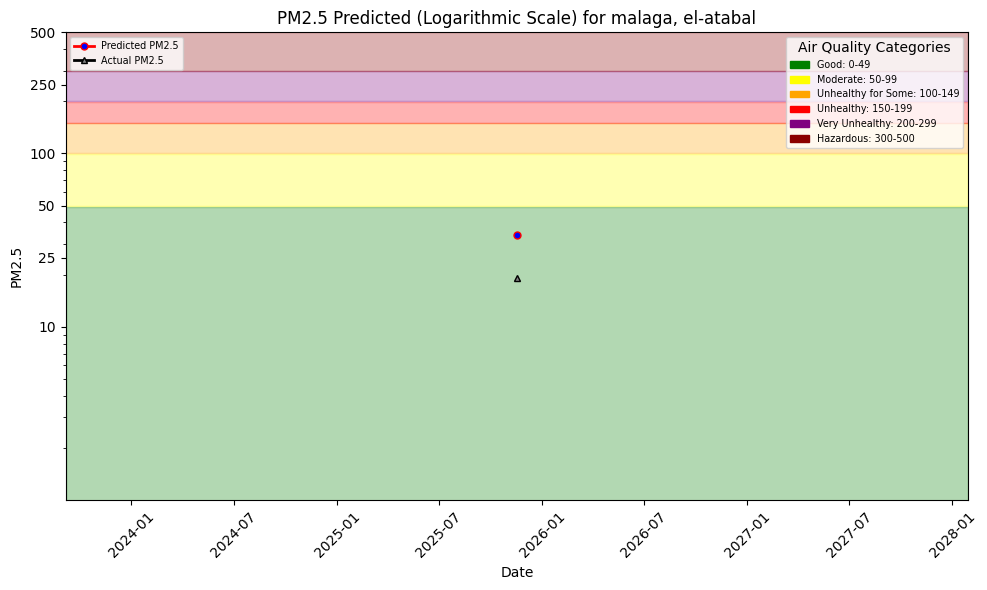

In [70]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [71]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/pshvaiko/Desktop/kth_scalable_ml/hw1/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: …

Uploading /home/pshvaiko/Desktop/kth_scalable_ml/hw1/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1298580/settings/fb/path/Resources/airquality


---